In [1]:
import pandas as pd

In [2]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
from gensim.corpora.dictionary import Dictionary

#предобработка текстов
import re
import numpy as np

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

from razdel import tokenize # https://github.com/natasha/razdel

import pymorphy2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Professional\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

morph = pymorphy2.MorphAnalyzer()

151


In [6]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [7]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [8]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_6916/3066725202.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 38.6 s


In [9]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 5min 53s


In [10]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Создание корпуса из списка текстов
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [11]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 56.4 s


In [12]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [13]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(1, 0.19648807),
 (3, 0.19351731),
 (6, 0.04868411),
 (8, 0.04962512),
 (18, 0.49384394)]

In [14]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: статья поверхность товар восток египет теория ст
topic_1: год это который мочь сша свой время
topic_2: ребёнок суд квартира выяснить лаборатория дело расследование
topic_3: наука врач рак это лечение организм космонавт
topic_4: суд компания источник иск разместить решение клиент
topic_5: расчёт констатировать дикий рисунок седьмой прага джордж
topic_6: россия это который российский nn президент проект
topic_7: ракета гражданин санкция источник операция эксперимент также
topic_8: закон это орган мочь сотрудник власть документ
topic_9: это nn который россия снижение мочь свой
topic_10: год рост страна фонд это который правительство
topic_11: это который земля день всё мозг мочь
topic_12: военный дело проверка уголовный министерство преступление год
topic_13: газ взрыв турция достигать захватить сбить удар
topic_14: человек произойти мужчина погибнуть результат выяснить вода
topic_15: банк украина пенсия украинский который это пострадать
topic_16: убийство украина следователь обв

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [15]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [16]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.399981,0.0,0.000000,...,0.0,0.0,0.0,0.098022,0.0,0.0,0.0,0.000000,0.0,0.0
1,4896,0.0,0.000000,0.000000,0.000000,0.056593,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.306237,0.0,0.0,0.0,0.000000,0.0,0.0
2,4897,0.0,0.196496,0.000000,0.193500,0.000000,0.0,0.048682,0.0,0.049633,...,0.0,0.0,0.0,0.493848,0.0,0.0,0.0,0.000000,0.0,0.0
3,4898,0.0,0.000000,0.000000,0.314213,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.069683,0.0,0.0,0.0,0.000000,0.0,0.0
4,4899,0.0,0.000000,0.182361,0.119473,0.000000,0.0,0.460910,0.0,0.000000,...,0.0,0.0,0.0,0.082396,0.0,0.0,0.0,0.087985,0.0,0.0


### Следующий шаг - векторные представления пользователей

In [17]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [18]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [19]:
doc_dict[293622]

array([0.        , 0.32897466, 0.        , 0.        , 0.02908104,
       0.03059062, 0.12707673, 0.        , 0.11410123, 0.        ,
       0.        , 0.10339784, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01682204, 0.08127106, 0.03566455,
       0.04487427, 0.        , 0.        , 0.07963954, 0.        ])

In [20]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, function=np.mean):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = function(user_vector, 0)
    return user_vector

In [21]:
get_user_embedding(user_articles_list)

array([0.        , 0.15714322, 0.02819794, 0.05065892, 0.00392723,
       0.        , 0.22210036, 0.05096352, 0.11435334, 0.04518681,
       0.06914738, 0.01254264, 0.03361787, 0.        , 0.        ,
       0.        , 0.05155283, 0.        , 0.        , 0.10361828,
       0.        , 0.03167427, 0.00413843, 0.        , 0.0098719 ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [22]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [23]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [24]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.096421,0.005090,0.000000,0.037300,0.005098,0.021179,0.025418,0.102296,...,0.010451,0.013335,0.002804,0.074285,0.249522,0.007479,0.184560,0.004706,0.030642,0.015667
1,u108690,0.000000,0.150591,0.041777,0.013336,0.005732,0.000000,0.157819,0.012670,0.052208,...,0.064133,0.040146,0.000000,0.008074,0.101754,0.009829,0.071035,0.006110,0.004493,0.000000
2,u108339,0.012879,0.054119,0.017797,0.058609,0.008384,0.000000,0.116406,0.032671,0.030226,...,0.013470,0.031242,0.000000,0.000000,0.162375,0.000000,0.045363,0.005108,0.000000,0.013706


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [25]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [26]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.096421,0.005090,0.000000,0.037300,0.005098,0.021179,0.025418,0.102296,...,0.013335,0.002804,0.074285,0.249522,0.007479,0.184560,0.004706,0.030642,0.015667,0
1,u108690,0.000000,0.150591,0.041777,0.013336,0.005732,0.000000,0.157819,0.012670,0.052208,...,0.040146,0.000000,0.008074,0.101754,0.009829,0.071035,0.006110,0.004493,0.000000,1
2,u108339,0.012879,0.054119,0.017797,0.058609,0.008384,0.000000,0.116406,0.032671,0.030226,...,0.031242,0.000000,0.000000,0.162375,0.000000,0.045363,0.005108,0.000000,0.013706,1


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [28]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [29]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [30]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1544615 , 0.06415399, 0.51463997, 0.25518368, 0.01867277,
       0.13611819, 0.15735027, 0.07419146, 0.27376166, 0.12805776])

In [31]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [32]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.259367, F-Score=0.701, Precision=0.637, Recall=0.780


In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1646  109]
 [  55  190]]


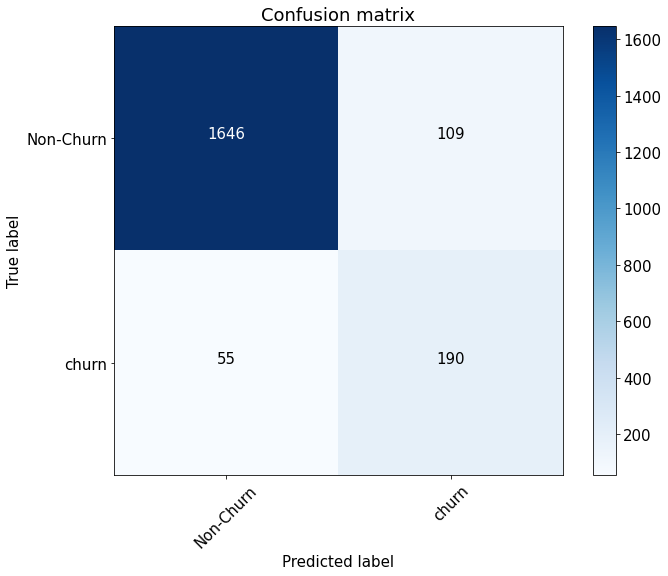

In [34]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Задание:
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
Повторить, но используя уже не медиану, а max.
Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [35]:
functions = [np.mean, np.median, np.max]
metrics = pd.DataFrame(columns=['Model', 'Best Threshold', 'F-Score', 'Precision', 'Recall', 'Roc_auc'])

for f in functions:
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, function=f), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    
    X = pd.merge(user_embeddings, target, 'left')
    
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)
    
    logreg.fit(X_train, y_train)
    
    preds = logreg.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    roc_auc = roc_auc_score(y_test, preds)
    
    metrics = metrics.append({'Model': f.__name__,
                    'Best Threshold': thresholds[ix],
                    'F-Score': fscore[ix],
                    'Precision': precision[ix],
                    'Recall': recall[ix],
                    'Roc_auc': roc_auc},
                   ignore_index=True)
    
metrics

,Model,Best Threshold,F-Score,Precision,Recall,Roc_auc
0,mean,0.259367,0.700917,0.636667,0.779592,0.953674
1,median,0.293936,0.811024,0.783270,0.840816,0.980494
2,amax,0.381042,0.824701,0.805447,0.844898,0.980162
